# FrugalAI challenge - Chainsaws - preparing a model for Pico

### Naive approach, `v5`


```
Copyright (c) 2025  @kelu124, Arm Limited, and Contributors. All rights reserved.

SPDX-License-Identifier: Apache-2.0
```

* Based on initial work by : [Sandeep Mistry](https://twitter.com/sandeepmistry), [Henri Woodcock](https://twitter.com/henriwoodcock) from the [Arm Software Developers team](https://twitter.com/armsoftwaredev)


Documentation :
* [The authors initial work](https://colab.research.google.com/github/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/ml_audio_classifier_example_for_pico.ipynb)
* This [notebook](https://colab.research.google.com/drive/16OmmqPclU-e1uhNwE0tGWASBocvlu5DA?usp=sharing)
* Other resources:
  * https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data


## Install dependencies

### Python Libraries

Let's start by installing the Python library dependencies:

In [ ]:
!pip install tf_keras

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
REDO = False

In [ ]:
#!pip install -r /content/drive/MyDrive/frugal/requirements.txt
!pip install tensorflow-io tensorflow tensorflow-model-optimization librosa matplotlib pandas datasets


In [ ]:
# # Pico related library
!pip install git+https://github.com/ARM-software/CMSIS_5.git@5.8.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/PythonWrapper
#!pip freeze > /content/drive/MyDrive/frugal/requirements.txt

  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.8.0) to /tmp/pip-install-urv32r1f/cmsisdsp_161838705952453d810a0c680ecfdc85
  Running command git clone --filter=blob:none --quiet https://github.com/ARM-software/CMSIS_5.git /tmp/pip-install-urv32r1f/cmsisdsp_161838705952453d810a0c680ecfdc85
  Running command git checkout -q 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Resolved https://github.com/ARM-software/CMSIS_5.git to commit 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Preparing metadata (setup.py) ... done
  Created wheel for CMSISDSP: filename=CMSISDSP-1.0.0-cp311-cp311-linux_x86_64.whl size=1354759 sha256=d85c265f072c1f6a996823ad5147822820f665eb2753f3739284ecb26b3541e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ywb3njjf/wheels/b2/84/47/073dc9eab0d876dd32dff0c0bd5b60722ce49118d120a6bcb5
Successfully built CMSISDSP


In [ ]:
!python --version
!pip --version


Python 3.11.11
pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)


In [ ]:
import tensorflow as tf
# Connect to google drive

print(tf.version.GIT_VERSION, tf.version.VERSION)
print(tf.__version__)

import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import soundfile as sf
import json
from os import path
from datasets import load_dataset

v2.17.0-18-g3c92ac03cab 2.17.1
2.17.1


## Baseline model

Dataset: HuggingFace: "rfcx/frugalai"

### Prepare dataset

#### Download and extract

In [ ]:
# download the dataset
# Have your HuggingFace HF_TOKEN ready and made available!
if not os.path.isfile("/content/drive/MyDrive/frugal/datasets/train.parquet.gzip") or REDO:
  dasaset = load_dataset(
    "rfcx/frugalai",
    name="default",
    num_proc=10,
    cache_dir="cache/"
  )

In [ ]:
%%shell
mkdir -p "/content/drive/MyDrive/frugal/"
mkdir -p "/content/drive/MyDrive/frugal/datasets/"
mkdir -p "/content/drive/MyDrive/frugal/datasets/frugalai"
mkdir -p "/content/drive/MyDrive/frugal/datasets/frugalai/wav/"
mkdir -p "./wav/"


In [ ]:
%%shell
cp "/content/drive/MyDrive/frugal/datasets/train.parquet.gzip" "train.parquet.gzip"

In [171]:
# Choose the setting of spectrogram between
# 1 for create_spectrogram_for_map
# 2 for create_arm_spectrogram_for_map
# 3 Mel spectrogram

choice = "1"# input("Choose \n1. create_spectrogram_for_map. \n2. create_arm_spectrogram_for_map. \n3. create_mel_spectrogram_for_map: ")
spectrogram_setting = "create_spectrogram_for_map"

if choice == "1":
  spectrogram_setting = "create_spectrogram_for_map"
  pass
elif choice == "2":
    spectrogram_setting = "create_arm_spectrogram_for_map"
elif choice == "3":
    spectrogram_setting = "create_mel_spectrogram_for_map"

print("Choice:",spectrogram_setting)

Choice: create_spectrogram_for_map


## Creating sound files

In [ ]:
# Takes 3 mins with T4 instance
# 29s when files exist
if not os.path.isfile("/content/drive/MyDrive/frugal/datasets/train.parquet.gzip") or REDO:
  for x in range(len(dasaset["train"])):
    d = dasaset["train"][x]
    # Saves WAVs to the DRIVE folder
    if REDO:
      filepath = "wav/"+d["audio"]["path"]
    else:
      filepath = "/content/drive/MyDrive/frugal/datasets/frugalai/wav/"+d["audio"]["path"]
    if not os.path.isfile(filepath):
      if len(d['audio']['array']) == 36000:
        sf.write(filepath, d["audio"]["array"], d["audio"]["sampling_rate"])


In [ ]:
# Takes 30s ish
if not os.path.isfile("/content/drive/MyDrive/frugal/datasets/train.parquet.gzip") or REDO:
  LEN = len(dasaset["train"])
  train = {}
  for x in range(LEN):
    d = dasaset["train"][x]
    train[x] = {"path":d["audio"]["path"], "sampling_rate":d["audio"]["sampling_rate"],"label":d["label"]}
  DF = pd.DataFrame(train).T
  DF.to_parquet("/content/drive/MyDrive/frugal/datasets/train.parquet.gzip",compression="gzip")
else:
  DF = pd.read_parquet("/content/drive/MyDrive/frugal/datasets/train.parquet.gzip")

if REDO:
  # linked to #TOTEST: if copying files from drive accelerate reading from them
  base_data_path = './wav/'
else:
  base_data_path = '/content/drive/MyDrive/frugal/datasets/frugalai/wav/'

# Create the 'fullpath' column first
DF['fullpath'] = DF['path'].map(lambda x: path.join(base_data_path, x))
# Now filter using the newly created 'fullpath' column
DF = DF[DF['fullpath'].apply(lambda x: os.path.isfile(x))]
DF.head()

,path,sampling_rate,label,fullpath
0,pooks_6ebcaf77-aa92-4f10-984e-ecc5a919bcbb_41-...,12000,1,/content/drive/MyDrive/frugal/datasets/frugala...
1,warsi_2020_1275aa58-5cf4-4620-9c8f-78e1cb39864...,12000,0,/content/drive/MyDrive/frugal/datasets/frugala...
2,warsi_2021_ec626f56-e094-4729-bf1f-e3737e09231...,12000,0,/content/drive/MyDrive/frugal/datasets/frugala...
3,warsi_2020_c74e499c-3720-4727-8213-1fe5f032f8c...,12000,0,/content/drive/MyDrive/frugal/datasets/frugala...
5,pooks_bcc12bdc-516a-4615-b642-590e66b697ad_80-...,12000,1,/content/drive/MyDrive/frugal/datasets/frugala...


#### Load wave file data

We can then define a new function named `load_wav` to load audio samples from a wave file using TensorFlow's [`tf.io.read_file(...)`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) and[`tf.audio.decode_wav(...)`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) API's. The [`tfio.audio.resample(...)`](https://www.tensorflow.org/io/api_docs/python/tfio/audio/resample) API will be used to resample the audio samples at the specified sampling rate.

[librosa](https://librosa.org/)'s [`load(...)`](https://librosa.org/doc/main/generated/librosa.load.html) API will be used as a fallback if TensorFlow is unable to decode the wave file.


In [ ]:
import tensorflow_io as tfio
import librosa

def load_wav(filename, desired_sample_rate, desired_channels):
  try:
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=desired_channels)
    wav = tf.squeeze(wav, axis=-1)
  except:
    # fallback to librosa if the wav file can be read with TF
    filename = tf.cast(filename, tf.string)
    wav, sample_rate = librosa.load(filename.numpy().decode('utf-8'), sr=None, mono=(desired_channels == 1))

  wav = tfio.audio.resample(wav, rate_in=tf.cast(sample_rate, dtype=tf.int64), rate_out=tf.cast(desired_sample_rate, dtype=tf.int64))

  return wav

Now let's load the first wave file, from the pandas `DataFrame`, and plot it overtime using `matplotlib`. The [`IPython.display.Audio(...)`](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.Audio) API can be used to playback the audio samples inside the notebook.




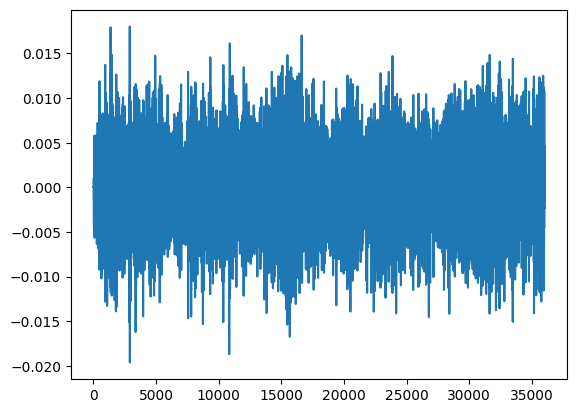

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

sample_rate = 12000
channels = 1

test_wav_file_path = DF.sample(1).reset_index(drop=True).iloc[0]['fullpath']
test_wav_data = load_wav(test_wav_file_path, sample_rate, channels)

plt.plot(test_wav_data)
plt.show()

display.Audio(test_wav_data, rate=sample_rate)

We can then use the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) TensorFlow API to create a pipeline that loads all wave file data from the dataset.

In [ ]:
# DF['folds'] = range(len(DF))
DF['folds'] = [x + 1 for x in range(len(DF))]
DF['folds'] = DF['folds'].apply(lambda x: int(x)%5)
DF["target"] = DF["label"]
DF['target'] = DF['target'].astype('int64')
DF['folds'] = DF['folds'].astype('int64')

fullpaths = DF['fullpath']
targets = DF['target']
folds = DF['folds']

fullpaths_ds = tf.data.Dataset.from_tensor_slices((fullpaths, targets, folds))
fullpaths_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Map each `fullpath` value to wave file samples:

In [ ]:
def load_wav_for_map(fullpath, label, fold):
  wav = tf.py_function(load_wav, [fullpath, sample_rate, channels], tf.float32)
  return wav, label, fold

wav_ds = fullpaths_ds.map(load_wav_for_map)
wav_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### Sanity checks

Let's remove empty wav files

In [ ]:
@tf.function
def wav_not_empty(wav):
  return tf.experimental.numpy.any(wav)

split_wav_ds = wav_ds.filter(lambda x, y, z: wav_not_empty(x))

#### Create Spectrograms

Rather than passing in the time series data directly into our TensorFlow model, we will transform the audio data into an audio spectrogram representation. This will create a 2D representation of the audio signal’s frequency content over time.

The input audio signal we will use will have a sampling rate of 16kHz, this means one second of audio will contain 16,000 samples. Using TensorFlow’s [`tf.signal.stft(...)`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) function we can transform a 3 second audio signal into a 2D tensor representation. We will choose a frame length of 256 and a frame step of 128, so the output of this feature extraction stage will be a Tensor that has a shape of `(280, 129)`.


In [160]:
@tf.function
def create_spectrogram(samples):
  SPC = tf.abs(
      tf.signal.stft(samples, frame_length=256, frame_step=128)
  )
  # len(np.array(SPC[:,0])) == 280
  # len(np.array(SPC[0,:])) == 129
  SPC = tf.reshape(SPC, shape=(280, 129))
  return SPC

spectrogram = create_spectrogram(test_wav_data)
spectrogram.shape

TensorShape([280, 129])

We can then create `plot_spectrogram` function to plot the spectrogram representation using `matplotlib`:

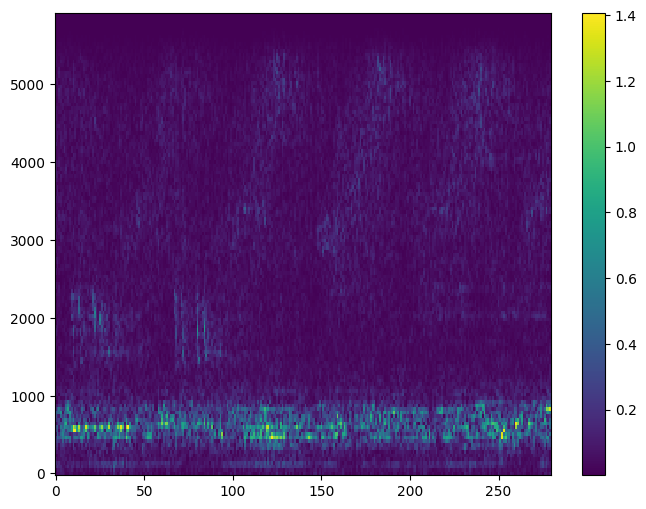

In [161]:
import numpy as np

def plot_spectrogram(spectrogram, vmax=None):
  transposed_spectrogram = tf.transpose(spectrogram)

  fig = plt.figure(figsize=(8,6))
  height = transposed_spectrogram.shape[0]
  X = np.arange(transposed_spectrogram.shape[1])
  Y = np.arange(height * int(sample_rate / 256), step=int(sample_rate / 256))

  im = plt.pcolormesh(X, Y, tf.transpose(spectrogram), vmax=vmax)

  fig.colorbar(im)
  plt.show()


plot_spectrogram(spectrogram)

Then we can map each split wave item to a spectrogram:

In [162]:
import cmsisdsp
from numpy import pi as PI

window_size = 256
step_size = 128

hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
  hanning_window_f32[i] = 0.5 * (1 - cmsisdsp.arm_cos_f32(2 * PI * i / window_size ))

hanning_window_q15 = cmsisdsp.arm_float_to_q15(hanning_window_f32)

rfftq15 = cmsisdsp.arm_rfft_instance_q15()
status = cmsisdsp.arm_rfft_init_q15(rfftq15, window_size, 0, 1)

@tf.function
def get_arm_spectrogram(waveform):
    # Normalize waveform to [-1, 1] before conversion
    waveform = waveform / np.max(np.abs(waveform))

    # Convert the audio to Q15
    waveform_q15 = cmsisdsp.arm_float_to_q15(waveform)

    num_frames = int(1 + (len(waveform) - window_size) // step_size)
    fft_size = int(window_size // 2 + 1)

    # Create empty spectrogram array
    spectrogram_q15 = np.empty((num_frames, fft_size), dtype=np.int16)

    start_index = 0
    for index in range(num_frames):
        # Take the window from the waveform.
        window = waveform_q15[start_index:start_index + window_size]

        # Apply the Hanning Window.
        window = cmsisdsp.arm_mult_q15(window, hanning_window_q15)

        # Calculate the FFT
        window = cmsisdsp.arm_rfft_q15(rfftq15, window)

        # Take the absolute value of the FFT and add to the spectrogram.
        spectrogram_q15[index] = cmsisdsp.arm_cmplx_mag_q15(window)[:fft_size]

        # Increase the start index of the window by the overlap amount.
        start_index += step_size

    # Convert to numpy output ready for keras
    return cmsisdsp.arm_q15_to_float(spectrogram_q15).reshape(num_frames, fft_size)


In [163]:
@tf.function
def create_mel_spectrogram(samples, sample_rate=16000, num_mel_bins=128):
    # Compute the STFT
    stft = tf.signal.stft(samples, frame_length=256, frame_step=128)
    spectrogram = tf.abs(stft)

    # Define the Mel filter bank
    num_spectrogram_bins = stft.shape[-1]
    lower_edge_hertz = 80.0  # Lower frequency bound
    upper_edge_hertz = sample_rate / 2.0  # Nyquist frequency

    # Create the Mel weight matrix
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz,
    )

    # Apply the Mel transformation
    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    mel_spectrogram = tf.reshape(mel_spectrogram, shape=(280, 129))
    return mel_spectrogram

In [172]:
def create_spectrogram_for_map(samples, label, fold):
    return create_spectrogram(samples), label, fold

def create_arm_spectrogram_for_map(samples, label, fold):
  spectrogram = tf.py_function(get_arm_spectrogram, [samples], tf.float32)
  return spectrogram, label, fold

def create_mel_spectrogram_for_map(samples, label, fold):
  spectrogram = tf.py_function(create_mel_spectrogram, [samples], tf.float32)
  return spectrogram, label, fold


if spectrogram_setting == "create_arm_spectrogram_for_map":
    spectrograms_ds = split_wav_ds.map(create_arm_spectrogram_for_map)
    spectrograms_ds.element_spec
elif spectrogram_setting == "create_mel_spectrogram_for_map":
    spectrograms_ds = split_wav_ds.map(create_mel_spectrogram_for_map)
    spectrograms_ds.element_spec
else:
    spectrograms_ds = split_wav_ds.map(create_spectrogram_for_map)
    spectrograms_ds.element_spec
print("Passed through ",spectrogram_setting)


Passed through  create_spectrogram_for_map


Let's plot the first 3 spectrograms in the dataset:

In [173]:
spectrograms_ds = split_wav_ds.map(create_spectrogram_for_map)
spectrograms_ds.element_spec

(TensorSpec(shape=(280, 129), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

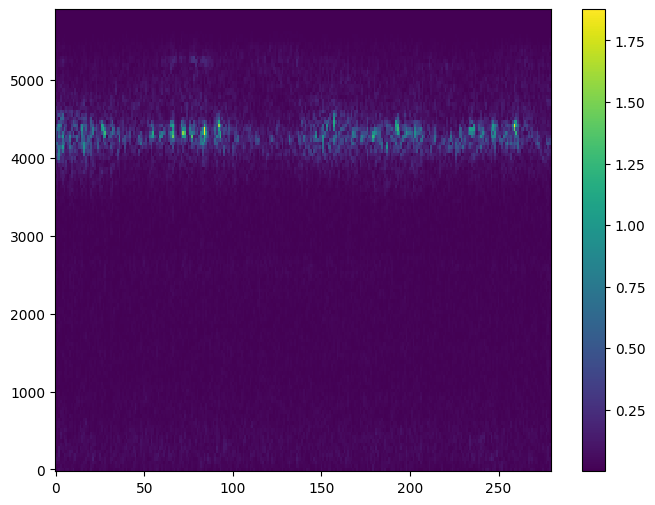

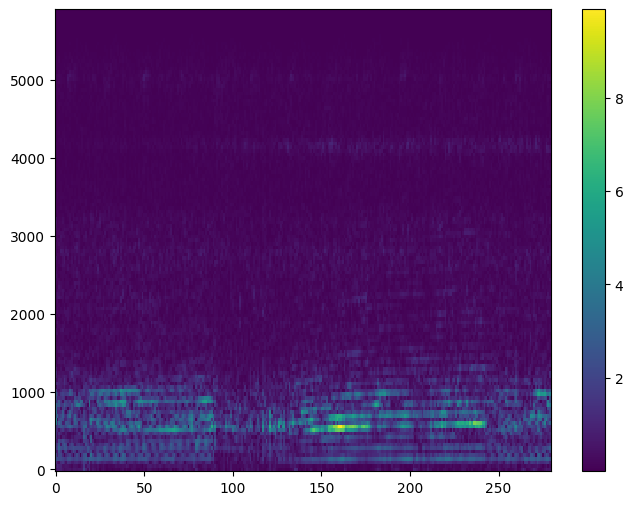

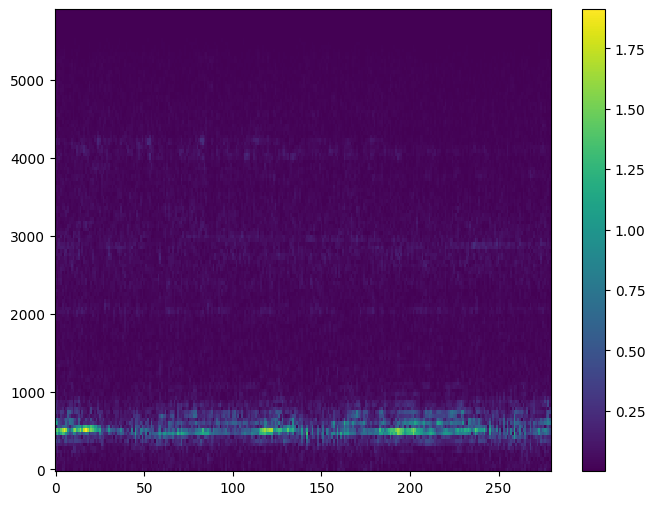

In [174]:
# 1min
for s, _, _ in spectrograms_ds.take(3):
  plot_spectrogram(s)

### Split Dataset

Before we start training the ML classifier model, we must split the dataset up in three parts: training, validation, and test.

We will use the same technique in TensorFlow's [Transfer learning with YAMNet for environmental sound classification](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data) guide, and use the `fold` column of the ESC-50 dataset to determine the split.

Before splitting the dataset, let's set a random seed for reproducibility:

In [175]:
import numpy as np
import tensorflow as tf


random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Entries with a `fold` value of less than 4 will used for training, the ones with a `value` will be used for validation, and finally the remaining items with be used for testing.

The `fold` column will be removed as it is no longer needed, and the dimensions of the spectrogram shape will be expanded from `(124, 129)` to `(124, 129, 1)`. The training items will also be shuffled.

In [176]:
#15s
cached_ds = spectrograms_ds.cache()

In [177]:
WeWantToSaveSpectroAsImgs = False

def explode_array_column(row):
  return pd.Series(row['spectrogram'])

if WeWantToSaveSpectroAsImgs:
  SAMPLESTOSAVE = 50 # 5 samples took 22s // 50 for 35s
  import tensorflow_datasets as tfds

  for labeltarget in [0,1]:
    SORTED = cached_ds.filter(lambda spectrogram, label, fold: label == labeltarget)

    signal = [x[0].astype(np.float16) for x in SORTED.take(SAMPLESTOSAVE).as_numpy_iterator()]
    label  = [x[1].astype(np.int8)    for x in SORTED.take(SAMPLESTOSAVE).as_numpy_iterator()]
    fold   = [x[2].astype(np.int8)    for x in SORTED.take(SAMPLESTOSAVE).as_numpy_iterator()]
    np.savez("/content/drive/MyDrive/frugal/v5_"+spectrogram_setting+"_label"+str(labeltarget)+".npz",signal = signal, label=label, fold=fold)


In [178]:
train_ds = cached_ds.filter(lambda spectrogram, label, fold: fold < 3)
val_ds = cached_ds.filter(lambda spectrogram, label, fold: fold == 3)
test_ds = cached_ds.filter(lambda spectrogram, label, fold: fold > 3)

# remove the folds column as it's no longer needed
# remove_fold_column = lambda spectrogram, label, fold: (tf.expand_dims(spectrogram, axis=-1), label)

def remove_fold_column(spectrogram, label, fold):
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    print("The spectrogram Shape", spectrogram.shape)
    # tf.debugging.assert_shapes([(spectrogram, (None, None, 1))])
    return spectrogram, label

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

# Inspect the data shape before batching
for spectrogram, label in train_ds.take(1):
    print(f"Before batch: spectrogram shape: {spectrogram.shape}, label shape: {label.shape}")

train_ds = train_ds.cache()  # Cache the dataset first to keep data in memory
train_ds = train_ds.shuffle(buffer_size=100, seed=random_seed)  # Shuffle after caching
train_ds = train_ds.batch(BATCHSIZE, drop_remainder=True)  # Batch the dataset
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache()  # Prefetch the data for better performance
val_ds = val_ds.cache().batch(BATCHSIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.cache().batch(BATCHSIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()


The spectrogram Shape (280, 129, 1)
The spectrogram Shape (280, 129, 1)
The spectrogram Shape (280, 129, 1)
Before batch: spectrogram shape: (280, 129, 1), label shape: ()


In [131]:
DF['folds'].unique()

array([1, 2, 3, 4, 0])

In [132]:
spectrograms_ds

<_MapDataset element_spec=(TensorSpec(shape=(280, 129), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Train Model

Now that we have the features extracted from the audio signal, we can create a model using TensorFlow’s Keras  API. The model will consist of 8 layers:

 1. An input layer.
 1. A preprocessing layer, that will resize the input tensor from 124x129x1 to 32x32x1.
 1. A normalization layer, that will scale the input values between -1 and 1
 1. A 2D convolution layer with: 8 filters, a kernel size of 8x8, and stride of 2x2, and ReLU activation function.
 1. A 2D max pooling layer with size of 2x2
 1. A flatten layer to flatten the 2D data to 1D
 1. A dropout layer, that will help reduce overfitting during training
 1. A dense layer with 50 outputs and a softmax activation function, which outputs the likelihood of the sound category (between 0 and 1).


Before we build the model using [Tensflow's Keras API's](https://www.tensorflow.org/api_docs/python/tf/keras), we will create normalization layer and feed in all the spectrogram dataset items.

In [133]:
#around 1min
for spectrogram, _, _ in cached_ds.take(1):
    input_shape = tf.expand_dims(spectrogram, axis=-1).shape
    print('Input shape:', input_shape)
    norm_data = tf.reshape(spectrogram, (input_shape[0], input_shape[1], 1))
    print("Norm Data Shape:", norm_data.shape)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(norm_data)

Input shape: (280, 129, 1)
Norm Data Shape: (280, 129, 1)


Define a sequential 8 layer model as described above:

In [179]:
if os.path.isfile(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras"):
  print("Loading the "+spectrogram_setting+" model")
  baseline_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras")
else:
  # baseline_model = tf.keras.models.Sequential([
  # https://stackoverflow.com/questions/66879748/what-is-the-difference-between-tf-keras-model-and-tf-keras-sequential
  baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Resizing(32, 32, interpolation="nearest"),
  norm_layer,
  tf.keras.layers.Conv2D(8, kernel_size=(8,8), strides=(2, 2), activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(2, activation='softmax')])

baseline_model.summary()

Loading the create_spectrogram_for_map model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 8)         520       
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dropout (D

Compile the model with `accuracy` metrics, an Adam optimizer and a sparse categorical crossentropy loss function. As well as define early stopping and dynamic learning rate scheduler callbacks for training.

In [ ]:
if os.path.isfile(f"/content/drive/MyDrive/frugal/baseline_model_v5_create_arm_spectrogram_for_map.keras"):
  if not os.path.isfile(f"/content/drive/MyDrive/frugal/baseline_model_v5_create_spectrogram_for_map.keras"):
    print("Loading default spectrogram if arm already done")
    baseline_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v5_create_arm_spectrogram_for_map.keras")

In [180]:
# Define metrics for model evaluation
METRICS = [
    "accuracy",
]

# Compile the model
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=25),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
]

Train the model:

In [181]:
# Durée de training:
# 570s / epoch for 200/20 (train/val) for batches of 32 (or with caching maybe, 416s for 200/20 in 32-batches -2s per batch)  (GPU)
# Now at 16/s for 32batches (GPU)
# Now at 17s/step with CPU
# Now at 16s/step for 32 batches (TPU v28)
# 8-batches; 500ms per batch  (GPU)
# 307s per step for batches of 256 elements  (GPU)
EPOCHS = 40
Ntrain = 20
NRecalc = int(20*32/BATCHSIZE)
print(Ntrain,BATCHSIZE,NRecalc)
history = baseline_model.fit(
    train_ds.take(NRecalc).cache(),
    validation_data=val_ds.take(NRecalc//10).cache(),
    epochs=EPOCHS,
    callbacks=callbacks
)

20 32 20
Epoch 1/40
20/20 [==============================] - 112s 5s/step - loss: 0.3299 - accuracy: 0.8734 - val_loss: 0.6368 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/40
20/20 [==============================] - 0s 10ms/step - loss: 0.3037 - accuracy: 0.8719 - val_loss: 0.6123 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/40
20/20 [==============================] - 0s 10ms/step - loss: 0.2919 - accuracy: 0.8672 - val_loss: 0.6450 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 4/40
20/20 [==============================] - 0s 10ms/step - loss: 0.3012 - accuracy: 0.8672 - val_loss: 0.6539 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 5/40
20/20 [==============================] - 0s 10ms/step - loss: 0.2708 - accuracy: 0.8875 - val_loss: 0.6818 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 6/40
20/20 [==============================] - 0s 10ms/step - loss: 0.2848 - accuracy: 0.8828 - val_loss: 0.5402 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/40
20/20 [==============================] - 0s 11ms/step - 

Evaluate the loss and accuracy of the test dataset:

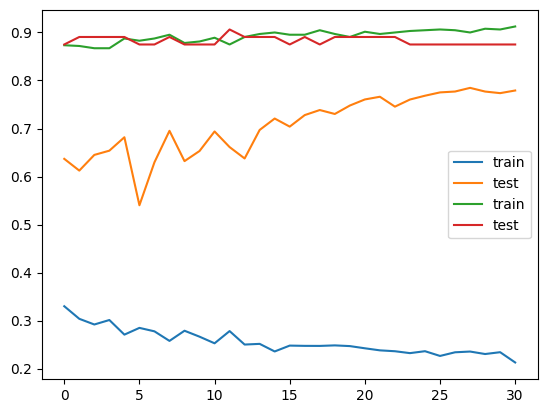

In [182]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

In [186]:
#Saves on drive
baseline_model.save(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras")
#Saves local machine
baseline_model.save(f"baseline_model_v5_{spectrogram_setting}.keras")

!zip -r /content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.zip /content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras
!zip -r baseline_model_v5_{spectrogram_setting}.zip baseline_model_v5_{spectrogram_setting}.keras

#Saves on drive
baseline_model.save(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras")
#Saves local machine
baseline_model.save(f"baseline_model_v5_{spectrogram_setting}.keras")


updating: content/drive/MyDrive/frugal/baseline_model_v5_create_spectrogram_for_map.keras (deflated 68%)
updating: baseline_model_v5_create_spectrogram_for_map.keras (deflated 68%)


### Scoring the model

In [ ]:
# @TODO: Why:
# WARNING:tensorflow:Using a while_loop for converting IO>AudioResample cause there is no registered converter for this op.

The baseline model has a relatively low accuracy ~80%.

Save the model:

In [187]:
# Evaluation on CPU for take 20 is around TOOLONG s (12s/step - becoming 40s/step)
# Eval on CPU for take(1) is 16
weights = baseline_model.weights
score_baselinemodel = baseline_model.evaluate(test_ds.take(1).cache())
score = {"model": "baseline_model_v5_"+spectrogram_setting, "loss":score_baselinemodel[0], "accuracy":score_baselinemodel[1]}
with open(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.score.json", "w") as j:
  j.write(json.dumps(score))
score

1/1 [==============================] - 10s 10s/step - loss: 0.6297 - accuracy: 0.8125


{'model': 'baseline_model_v5_create_spectrogram_for_map',
 'loss': 0.6296855211257935,
 'accuracy': 0.8125}

# Model optim for pic0

## Model Optimization

To optimize the model to run on the Arm Cortex-M0+ processor, we will use a process called model quantization. Model quantization converts the model’s weights and biases from 32-bit floating-point values to 8-bit values. The [pico-tflmicro](https://github.com/raspberrypi/pico-tflmicro) library, which is a port of TFLu for the RP2040’s Pico SDK contains Arm’s CMSIS-NN library, which supports optimized kernel operations for quantized 8-bit weights on Arm Cortex-M processors.

**Beware** of course this model should be based on the pico's arm's spectrogram, of course.


### Quantization Aware Training

We can use [TensorFlow’s Quantization Aware Training (QAT)](https://www.tensorflow.org/model_optimization/guide/quantization/training) feature to easily convert the floating-point model to quantized.

In [189]:
import tensorflow_model_optimization as tfmot

if os.path.isfile(f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras"):
  # We load an existing quantified model
  print("Loading a model from",f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras")
  quant_aware_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras")
else:
  # We load the non quant'ed model to process it
  final_model = tf.keras.models.load_model(f"/content/drive/MyDrive/frugal/baseline_model_v5_{spectrogram_setting}.keras")
  supported_layers = [tf.keras.layers.Conv2D, tf.keras.layers.Dense, tf.keras.layers.ReLU]

  def apply_quantization_to_dense(layer):
    for supported_layer in supported_layers:
      if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

  def apply_qat_to_dense_and_cnn(layer):
    if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

  annotated_model = tf.keras.models.clone_model(
      final_model,
      clone_function=apply_qat_to_dense_and_cnn,
  )

  quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 quant_conv2d (QuantizeWrap  (None, 13, 13, 8)         539       
 perV2)                                                          
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                        

In [190]:
quant_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

In [191]:
EPOCHS=40 # 295s on T4 for 100 items, 10 tests
quant_aware_history = quant_aware_model.fit(
    train_ds.take(20).cache(),
    validation_data=val_ds.take(10).cache(),
    epochs=EPOCHS
)

Epoch 1/40
20/20 [==============================] - 153s 7s/step - loss: 0.6368 - accuracy: 0.6234 - val_loss: 0.6438 - val_accuracy: 0.6000
Epoch 2/40
20/20 [==============================] - 0s 13ms/step - loss: 0.6122 - accuracy: 0.6422 - val_loss: 0.6249 - val_accuracy: 0.6219
Epoch 3/40
20/20 [==============================] - 0s 14ms/step - loss: 0.5911 - accuracy: 0.6578 - val_loss: 0.6066 - val_accuracy: 0.6469
Epoch 4/40
20/20 [==============================] - 0s 13ms/step - loss: 0.5775 - accuracy: 0.6750 - val_loss: 0.5994 - val_accuracy: 0.6594
Epoch 5/40
20/20 [==============================] - 0s 18ms/step - loss: 0.5730 - accuracy: 0.6812 - val_loss: 0.5880 - val_accuracy: 0.6656
Epoch 6/40
20/20 [==============================] - 0s 13ms/step - loss: 0.5616 - accuracy: 0.7031 - val_loss: 0.5732 - val_accuracy: 0.6969
Epoch 7/40
20/20 [==============================] - 0s 13ms/step - loss: 0.5435 - accuracy: 0.7156 - val_loss: 0.5604 - val_accuracy: 0.7125
Epoch 8/40
20

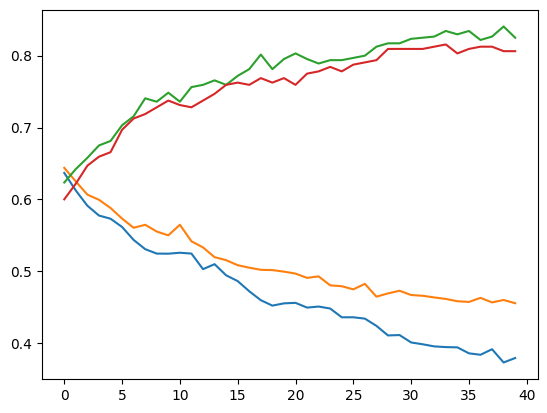

In [192]:
from matplotlib import pyplot

pyplot.plot(quant_aware_history.history['loss'], label='train')
pyplot.plot(quant_aware_history.history['val_loss'], label='test')

pyplot.plot(quant_aware_history.history['accuracy'], label='train')
pyplot.plot(quant_aware_history.history['val_accuracy'], label='test')

In [193]:
#Saving the quantified model

In [196]:
#Saves on drive
quant_aware_model.save(f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras")
#Saves local machine
quant_aware_model.save(f"quant_aware_model_v5_{spectrogram_setting}_QAT.keras")

!zip -r /content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.zip /content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras
!zip -r quant_aware_model_v5_{spectrogram_setting}_QAT.zip quant_aware_model_v5_{spectrogram_setting}_QAT.keras

#Saves on drive
quant_aware_model.save(f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}_QAT.keras")
#Saves local machine
quant_aware_model.save(f"quant_aware_model_v5_{spectrogram_setting}_QAT.keras")


updating: content/drive/MyDrive/frugal/quant_aware_model_v5_create_spectrogram_for_map_QAT.keras (deflated 73%)
updating: quant_aware_model_v5_create_spectrogram_for_map_QAT.keras (deflated 73%)


In [197]:
# Eval on CPU for take(1) is 9s fot QAT
score_QATmodel = quant_aware_model.evaluate(test_ds.take(2).cache())
score = {"model": "baseline_model_v5_"+spectrogram_setting, "loss":score_QATmodel[0], "accuracy":score_QATmodel[1]}
with open(f"/content/drive/MyDrive/frugal/quant_aware_model_v5_{spectrogram_setting}.score.json", "w") as j:
  j.write(json.dumps(score))
score

2/2 [==============================] - 16s 8s/step - loss: 0.4899 - accuracy: 0.7969


{'model': 'baseline_model_v5_create_spectrogram_for_map',
 'loss': 0.4899435341358185,
 'accuracy': 0.796875}

### Saving model in TFLite format

We will now use the [tf.lite.TFLiteConverter.from_keras_model(...)](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_keras_model) API to convert the quantized Keras model to TF Lite format, and then save it to disk as a `.tflite` file.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

tflite = f"/content/drive/MyDrive/frugal/tflite_model_v5_{spectrogram_setting}.tflite"
with open(tflite, "wb") as f:
  f.write(tflite_model_quant)

In [ ]:
os.path.isfile(tflite)

In [ ]:
!echo "alignas(8) const unsigned char tflite_model[] = {" > /content/drive/MyDrive/frugal/tflite_v5_{spectrogram_setting}_model.h
!cat /content/drive/MyDrive/frugal/tflite_model_v5_{spectrogram_setting}.tflite | xxd -i                        >> /content/drive/MyDrive/frugal/tflite_v5_{spectrogram_setting}_model.h
!echo "};"                                               >> /content/drive/MyDrive/frugal/tflite_v5_{spectrogram_setting}_model.h

!echo "alignas(8) const unsigned char tflite_model[] = {" > tflite_model_v5.h
!cat /content/drive/MyDrive/frugal/tflite_model_v5_{spectrogram_setting}.tflite | xxd -i                        >> tflite_model_v5.h
!echo "};"                                               >> tflite_model_v5.h

### Test TF Lite model

Since TensorFlow also supports loading TF Lite models using [`tensorflow.lite`](https://www.tensorflow.org/api_docs/python/tf/lite), we can also verify the functionality of the quantized model and compare its accuracy with the regular unquantized model inside the notebook.

In [ ]:
DoTests = False

In [ ]:
import tensorflow.lite as tflite

print( f"Loading /content/drive/MyDrive/frugal/tflite_model_v5_{spectrogram_setting}.tflite")
# Load the interpreter and allocate tensors
interpreter = tflite.Interpreter( f"/content/drive/MyDrive/frugal/tflite_model_v5_{spectrogram_setting}.tflite")
interpreter.allocate_tensors()

# Load input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Set quantization values
input_scale, input_zero_point = input_details["quantization"]
output_scale, output_zero_point = output_details["quantization"]

Loading /content/drive/MyDrive/frugal/tflite_model_v5_create_arm_spectrogram_for_map.tflite


In [ ]:
input_scale, input_zero_point, "--",output_scale, output_zero_point, input_details['dtype']

(0.13396769762039185, -128, '--', 0.00390625, -128, numpy.int8)

In [ ]:
DoTests = True

In [ ]:
if DoTests:# Calculate the number of correct predictions
  correct = 0
  test_ds_len = 0

  # Loop through a part of the test set
  # For a take(100) it takes xx seconds on a T4 machine.
  for x, y in  test_ds.take(2).cache().unbatch():
    # original shape is [124, 129, 1] expand to [1, 124, 129, 1]
    x = tf.expand_dims(x, 0).numpy()
    if not test_ds_len%10:
      print(test_ds_len)
    # quantize the input value
    if (input_scale, input_zero_point) != (0, 0):
      x = x / input_scale + input_zero_point

    #X = np.float32(x)
    X = X.astype(input_details['dtype'])

    print(np.min(X),np.max(X))

    try:
      # add the input tensor to interpreter
      interpreter.set_tensor(input_details["index"], X)

      #run the model
      interpreter.invoke()

      # Get output data from model and convert to fp32
      output_data = interpreter.get_tensor(output_details["index"])
      output_data = output_data.astype(np.float32)

      # Dequantize the output
      if (output_scale, output_zero_point) != (0.0, 0):
        output_data = (output_data - output_zero_point) * output_scale

      # convert output to category
      if output_data[0][0] >= 0.5:
        category = 1
      else:
        category = 0

      # add 1 if category = y
      correct += 1 if category == y.numpy() else 0

      test_ds_len += 1
    except:
      pass

  #   break

In [ ]:
if DoTests:
  accuracy = correct / test_ds_len
  print(f"Accuracy for quantized model is {accuracy*100:.2f}% (to 2 D.P) on test set.")

In [ ]:
# PIP FREEZE
!pip freeze > /content/drive/MyDrive/frugal/requirements.txt

# Flashing

See https://colab.research.google.com/github/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/ml_audio_classifier_example_for_pico.ipynb#scrollTo=4gqmp3nPtp6P

In [185]:
pico = False

#### Inference Application

We now have a model that is ready to be deployed to the device! We’ve created an application template for inference which can be compiled with the .h file that we’ve generated for the model.

The C++ application uses the `pico-sdk` as the base, along with the `CMSIS-DSP`, `pico-tflmicro`, and `Microphone Libary for Pico` libraries. It’s general structure is as follows:
 1. Initialization
  1. Configure the board's built-in LED for output. The application will map the brightness of the LED to the output of the model. (0.0 LED off, 1.0 LED on with full brightness)
  1. Setup the TF Lite library and TF Lite model for inference
  1. Setup the CMSIS-DSP based DSP pipeline
  1. Setup and start the microphone for real-time audio
 1. Inference loop
  1. Wait for 128 * 4 = 512 new audio samples from the microphone
  1. Shift the spectrogram array over by 4 columns
  1. Shift the audio input buffer over by 128 * 4 = 512 samples and copy in the new samples
  1. Calculate 4 new spectrogram columns for the updated input buffer
  1. Perform inference on the spectrogram data
  1. Map the inference output value to the on-board LED’s brightness and output the status to the USB port

In-order to run in real-time each cycle of the inference loop must take under (512 / 16000) = 0.032 seconds or 32 milliseconds. The model we’ve trained and converted takes 24 ms for inference, which gives us ~8 ms for the other operations in the loop.

128 was used above to match the stride of 128 used in the training pipeline for the spectrogram. We used a shift of 4 in the spectrogram to fit within the real-time constraints we had.

The source code for the inference application can be found on GitHub: https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/tree/main/inference-app

**Note:** We have already cloned this project in the setup steps from earlier.


In [ ]:
import tensorflow as tf
if pico:
  tf.keras.utils.get_file('cmake-3.21.0-linux-x86_64.tar.gz',
                          'https://github.com/Kitware/CMake/releases/download/v3.21.0/cmake-3.21.0-linux-x86_64.tar.gz',
                          cache_dir='./',
                          cache_subdir='tools',
                          extract=True)

  tf.keras.utils.get_file('gcc-arm-none-eabi-10-2020-q4-major-x86_64-linux.tar.bz2',
                          'https://developer.arm.com/-/media/Files/downloads/gnu-rm/10-2020q4/gcc-arm-none-eabi-10-2020-q4-major-x86_64-linux.tar.bz2',
                          cache_dir='./',
                          cache_subdir='tools',
                          extract=True)

In [ ]:
!apt-get install -y xxd

In [ ]:
import os

os.environ['PATH'] = f"{os.getcwd()}/tools/cmake-3.21.0-linux-x86_64/bin:{os.environ['PATH']}"
os.environ['PATH'] = f"{os.getcwd()}/tools/gcc-arm-none-eabi-10-2020-q4-major/bin:{os.environ['PATH']}"

In [ ]:
%%shell
git clone --branch 1.2.0 https://github.com/raspberrypi/pico-sdk.git
cd pico-sdk
git submodule init
git submodule update

In [ ]:
os.environ['PICO_SDK_PATH'] = f"{os.getcwd()}/pico-sdk"

In [ ]:
# for Raspberry Pi Pico (uncomment next line)
os.environ['PICO_BOARD'] = 'pico'
# for SparkFun MicroMod
# os.environ['PICO_BOARD'] = 'sparkfun_micromod'
print(f"PICO_BOARD env. var. set to '{os.environ['PICO_BOARD']}'")

In [ ]:
%%shell
git clone --recurse-submodules https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico.git

In [ ]:
%%shell
ln -s ml-audio-classifier-example-for-pico/colab_utils colab_utils
ln -s ml-audio-classifier-example-for-pico/inference-app inference-app

#### Compile Inference Application

Once again we can use `cmake` to setup project before compiling it:

In [ ]:
!cp tflite_model.h inference-app/src/tflite_model.h

In [ ]:
%%shell
cd inference-app
mkdir -p build
cd build
cmake .. -DPICO_BOARD=${PICO_BOARD}

cd inference-app/build

make -j

#### Flash inferencing application to board

You’ll need to put the board into USB boot ROM mode again to load the new application to it. If you are using a WebUSB API enabled browser like Google Chrome, you can directly flash the image onto the board from within Google Collab! Otherwise, you can manually download the .uf2 file to your computer and then drag it onto the USB disk for the RP2040 board.

**Note for Windows**: If you are using Windows you must install WinUSB drivers in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/windows.md).

**Note for Linux**: If you are using Linux you must configure udev in order to use WebUSB, you can do so by following the instructions found [here](https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/blob/main/linux.md).

 * SparkFun MicroMod
  * Plug the USB-C cable into the board and your PC to power the board
  * While holding down the BOOT button on the board, tap the RESET button

 * Raspberry Pi Pico
  * Plug the USB Micro cable into your PC, but do NOT plug in the Pico side.
  * While holding down the white BOOTSEL button, plug in the micro USB cable to the Pico


Then run the code cell below and click the "flash" button.

In [ ]:
from colab_utils.pico import flash_pico
if pico:
  flash_pico('inference-app/build/pico_inference_app.bin')

In [ ]:
if pico:
  for wav, _, _ in fire_alarm_wav_ds:
    display.display(display.Audio(wav, rate=sample_rate))

In [ ]:
from colab_utils.serial_monitor import run_serial_monitor

if pico:
  run_serial_monitor()